<a href="https://colab.research.google.com/github/madhav3099/Language-Translation_RNN/blob/master/Language_Translation_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [0]:
import numpy as np

In [0]:
!wget http://www.manythings.org/anki/deu-eng.zip

In [0]:
!unzip deu-eng.zip

In [0]:
def read_text(filename):
  file = open(filename,mode="rt",encoding="utf-8")
  text =file.read()
  file.close()
  return text


def to_lines(text):
    pairs = text.strip().split('\n')
    sents = [p.split('\t') for p in pairs]
    return sents

 
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = np.array(deu_eng)


deu_eng[0]

In [0]:
deu_eng = deu_eng[:50000,:]

In [0]:
import string


deu_eng[:,0] = [s.translate(str.maketrans("","",string.punctuation))for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans("","",string.punctuation))for s in deu_eng[:,1]]

In [12]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['You need not go there', 'Du musst nicht dorthin gehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813634 (Pfirsichbaeumchen)'],
       ['You need not go there', 'Du brauchst nicht dorthin zu gehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813635 (Pfirsichbaeumchen)'],
       ['You need to apologize', 'Du musst dich entschuldigen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3826573 (CK) & #3928528 (Tamy)']],
      dtype='<U537')

In [0]:
for i in range(len(deu_eng)):
  deu_eng[i,0] = deu_eng[i,0].lower()
  deu_eng[i,1] = deu_eng[i,1].lower()


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd


In [0]:
eng_len = [len(s.split()) for s in deu_eng[:,0]]
deu_len = [len(s.split()) for s in deu_eng[:,1]]


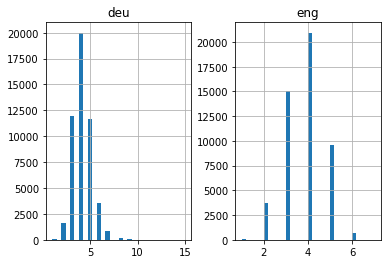

In [17]:
lenghts_df = pd.DataFrame({'eng':eng_len , 'deu':deu_len})
lenghts_df.hist(bins=30)
plt.show()


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


In [21]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(deu_eng[:,0])
eng_vocab_size = len(eng_tokenizer.word_index) +1
print(eng_vocab_size)


6331


In [22]:
deu_tokenizer = Tokenizer()
deu_tokenizer.fit_on_texts(deu_eng[:,1])
deu_vocab_size = len(deu_tokenizer.word_index) +1
print(deu_vocab_size)

10455


In [0]:
eng_max_length = 8
deu_max_length = 8

In [0]:
def encode_sequences(tokenizer,length,lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(seq,maxlen=length,padding='post')
  return seq

In [0]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(deu_eng,test_size =0.2,random_state =12)

In [31]:
trainX = encode_sequences(deu_tokenizer , deu_max_length , train[:,1])

trainY = encode_sequences(eng_tokenizer , eng_max_length , train[:,0])

print(trainX.shape , trainY.shape)


(40000, 8) (40000, 8)


In [32]:
print(trainX[0])

[  1 109   5 326   0   0   0   0]


In [34]:
testX = encode_sequences(deu_tokenizer , deu_max_length , test[:,1])

testY = encode_sequences(eng_tokenizer , eng_max_length , test[:,0])

print(testX.shape , testY.shape)


(10000, 8) (10000, 8)


In [0]:
from keras.models import Sequential
from keras.layers import Dense , LSTM ,RepeatVector
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint

In [36]:
model = Sequential()
model.add(Embedding(deu_vocab_size , 512 , input_length= deu_max_length , mask_zero= True))

model.add(LSTM(512))

model.add(RepeatVector(eng_max_length))
model.add(LSTM(512, return_sequences= True))

model.add(Dense(eng_vocab_size,activation="softmax"))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 512)            5352960   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 8, 6331)           3247803   
Total params: 12,799,163
Trainable params: 12,799,163
Non-trainable params: 0

In [0]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms , loss="sparse_categorical_crossentropy")

In [0]:
filename = "model.h1.2020_jan_15"
checkpoint = ModelCheckpoint(filename , monitor="val_loss" , mode="min", save_best_only=True ,verbose=1)

In [40]:
history = model.fit(trainX , trainY.reshape(40000,8,1) ,
                    epochs = 30,
                    batch_size= 512,
                    validation_split = 0.2,
                    callbacks =[checkpoint],
                    verbose =1)


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 7s 215us/step - loss: 3.4464 - val_loss: 2.8987

Epoch 00001: val_loss improved from inf to 2.89868, saving model to model.h1.2020_jan_15
Epoch 2/30
32000/32000 [==============================] - 5s 146us/step - loss: 2.8120 - val_loss: 2.7797

Epoch 00002: val_loss improved from 2.89868 to 2.77965, saving model to model.h1.2020_jan_15
Epoch 3/30
32000/32000 [==============================] - 5s 144us/step - loss: 2.6581 - val_loss: 2.5917

Epoch 00003: val_loss improved from 2.77965 to 2.59167, saving model to model.h1.2020_jan_15
Epoch 4/30
32000/32000 [==============================] - 5s 145us/step - loss: 2.4663 - val_loss: 2.4828

Epoch 00004: val_loss improved from 2.59167 to 2.48277, saving model to model.h1.2020_jan_15
Epoch 5/30
32000/32000 [==============================] - 5s 146us/step - loss: 2.3205 - val_loss: 2.3825

Epoch 00005: val_loss improved from 2.48277 to 

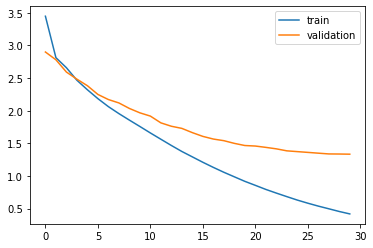

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train' , 'validation'])
plt.show()


In [0]:
from keras.models import load_model

In [0]:
model = load_model(filename)
preds = model.predict_classes(testX)

In [0]:
eng_dict = {t:w for w,t in eng_tokenizer.word_index.items()}


In [0]:
eng_preds = []
for p in preds:
  sent = []
  for t in p:
    w = eng_dict.get(t) if t > 0 else ""
    sent.append(w)
  eng_preds.append(' '.join(sent))

In [47]:
pred_df = pd.DataFrame({'actual' :test[:,0] , 'predicted':eng_preds})
pred_df.head(15)

,actual,predicted
0,tom banged his head,tom brushed his head
1,he is a dj,he is a
2,i like seafood,i like sweets
3,do it tomorrow,take again
4,do you need the phone,do you need the phone
5,this door wont shut,the door open open
6,i think youre stupid,i think youre nice
7,toms wife just died,toms is is fat
8,tom kept winning,tom took up
9,who do you live with,who are you for
